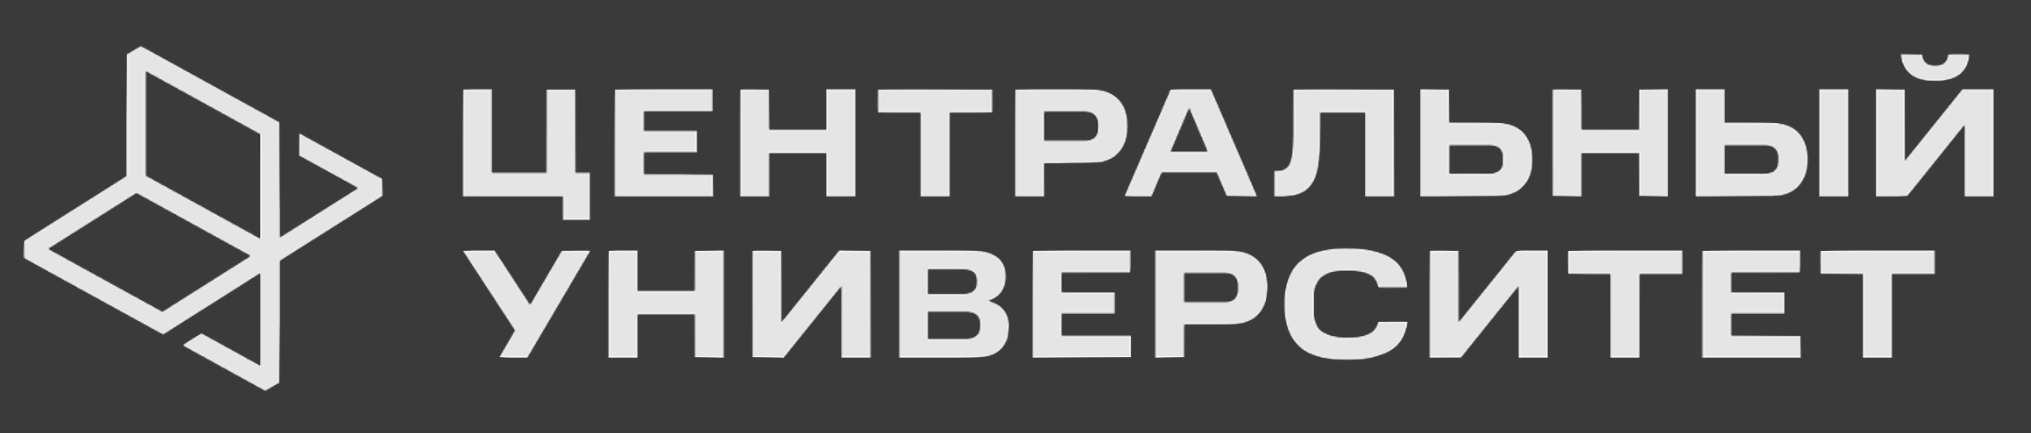

# Курс по Машинному обучению

## Домашнее задание 5. Линейная регрессия + Линейная классификация + SVM (20 баллов + 3 бонус)

## О сроках

Дата выдачи: 15.10.2023

Мягкий дедлайн: 23.10.2023 18:00 MSK

Жесткий дедлайн со штрафом: 30.10.2023 18:00 MSK (7 дней от мягкого дедлайна)

За каждый день просрочки снимается 5% от макс. балла (1 балл)

# Важно! О формате сдачи

* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулировке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**
*  **Если в ячейке написана фраза "Вывод"/"Ответ на вопрос"/"Ваш текст" и пр., то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно).**
* **Если в ячейке написано "Your code here"/"Ваш код" и пр., то ожидается ответ в виде кода (можете добавить больше ячеек с кодом, если считаете это необходимым, но это необязательно).**
* **Если есть и ячейка с фразой "Вывод" и пр., и ячейка с фразой "Your code here" и пр., то в ответе ожидается и код, и текст)**

## Часть 0. Подготовка

<font color='red'>Вам может понадобиться свежая версия sklearn 1.3</font>

In [1]:
! pip install scikit-learn -U --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 23.2 MB/s eta 0:00:00


In [2]:
import sklearn
assert(sklearn.__version__ == "1.3.1")

In [3]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.io as pio
import matplotlib_inline

import time
from tqdm.auto import tqdm

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, RocCurveDisplay, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC, SVC
from sklearn.inspection import DecisionBoundaryDisplay


sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
pio.templates.default = pio.templates.merge_templates("plotly_dark", "presentation")
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

pd.set_option('display.max_columns', None)

Если много warning будет, то можно включить:

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Часть 1. Линейная регрессия

###  <font color='orange'>Задача 1 [3 балла]</font>

Расскажите, почему при использовании регуляризации штрафуются только веса, но не свободный коэффициент $w_0$ (в некоторой литературе - $b$)?

Напомним, что предсказание линейной модели считается по формуле

$$a(x) = <w, x> + w_0$$

<font color='orange'>**Вывод:**</font> коэфициент $w_0$ соответствует отступу от начала координат. Он обеспечивает базовый уровень выхода модели даже при отсутствии входных признаков.

-------

Данные возьмем из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) (такие же, как на семинаре)

In [5]:
! gdown 1SKx5Shx5J1O45mKBmjCtQmUF7LXRUou-

Downloading...
From: https://drive.google.com/uc?id=1SKx5Shx5J1O45mKBmjCtQmUF7LXRUou-
To: /content/train.csv
100% 461k/461k [00:00<00:00, 80.4MB/s]


In [6]:
data = pd.read_csv("/content/train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Возьмем только вещественные фичи с минимальной обработкой:

In [7]:
X_numeric = data.select_dtypes(include='number').drop(["SalePrice"], axis=1).fillna(0)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_numeric, data.SalePrice, test_size=0.15, random_state=41)

###  <font color='orange'>Задача 2 [5 баллов]</font>

Подберите оптимальные параметры (`alpha` и `l1_ratio`) с помощью GridSearchCV, Pipeline для модели ElasticNet.

* Выведите их.
* Какое получилось качестве на тесте?
* Какие признаки получилось занулить? Как вы думаете, почему они занулились? (Можно [посмотреть на описание признаков посмотреть вот тут](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=test.csv) и [тут](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=data_description.txt))

В качестве метрики качества будем `по-прежнему использовать RMSE`

<font color='red'> Reminder:  </font> не забудьте сделать нормализацию данных.

<font color='red'> Важно!:  </font> обратите внимание на рекомендуемый порядок наполнения Pipeline для избежания утечек целевой переменной! Обсуждение можно найти в чате в телеграме, а также в отдельной секции в семинарском ноутбуке

Подсказка: дожно занулиться хотя бы 3 признака, если этого не произошло, перепроверьте сетку перебора или разбиения на train_test_split

* `alpha` рекомендуется перебирать про логарифмической шкале, хотя бы 10 значений
* `l1_ratio` - по линейной шкале, включая границы 0 и 1( границы значений [можно посмотреть тут](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) ), хотя бы 5 значений

In [9]:
# Ваш код тут
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1, 1))

In [10]:
model = ElasticNet()
clf_cv = GridSearchCV(
    estimator=model,
    cv=3,
    param_grid={
        'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 500, 1000, 10000],
        'l1_ratio': [0.05, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1]
    },
    scoring='neg_root_mean_squared_error'
)

clf_cv.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=3, estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 500,
                                   1000, 10000],
                         'l1_ratio': [0.05, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9,
                                      1]},
             scoring='neg_root_mean_squared_error')

In [11]:
print(clf_cv.best_score_, clf_cv.best_estimator_)
estim = clf_cv.best_estimator_
estim.coef_

-0.509861429338065 ElasticNet(alpha=0.1, l1_ratio=0.15)


array([-0.        , -0.05986957,  0.        ,  0.02756724,  0.28685686,
        0.03530888,  0.07410979,  0.06584986,  0.07337647,  0.0581928 ,
       -0.        , -0.        ,  0.05633645,  0.06664377,  0.04690955,
       -0.        ,  0.18003295,  0.0396107 ,  0.        ,  0.03095684,
        0.00253857, -0.04408368, -0.03076652,  0.06664366,  0.04761871,
       -0.02978543,  0.11278064,  0.02945195,  0.03312937,  0.        ,
       -0.        ,  0.        ,  0.02291542, -0.        , -0.        ,
       -0.        , -0.        ])

In [12]:
a_1 = scaler.inverse_transform(estim.predict(X_test_scaled).reshape(-1, 1))
a_2 = scaler.inverse_transform(estim.predict(X_train_scaled).reshape(-1, 1))
print('train RMSE:', np.sqrt(np.mean((np.array(y_train).reshape(-1) - np.array(a_2).reshape(-1)) ** 2)))
print('test RMSE:', np.sqrt(np.mean((np.array(y_test).reshape(-1) - np.array(a_1).reshape(-1)) ** 2)))

train RMSE: 36063.683382303774
test RMSE: 26263.571301736967


###  <font color='orange'>Задача 3 [4 балла]</font>

Теперь попробуем сделать следующее: обучить `Lasso` и посмотреть поведение количества зануляемых весов в зависимости от силы регуляризации.

* Изобразите график количества зануляемых весов в зависимости от коэффициента регуляризации `alpha`. Можно пользоваться любыми библиотеками визуализации
* Какой характер имеет зависимость?

In [13]:
import plotly.express as px

In [14]:
alphas = np.logspace(-3, 3, 40)  # Оставим как минимум такие границы, можно увеличивать
zero_coefs = np.array([])

for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=1000, tol=1e-5)
    #<Your code here>
    model.fit(X_train_scaled, y_train_scaled)
    a = model.coef_
    zero_coefs = np.append(zero_coefs, len(a[a == 0]))

In [15]:
fig = px.line(
    x = alphas,
    y = zero_coefs,
    title='Zero coefs with different alpha (log_x = True)',
    log_x=True
    )

fig.update_layout(
    yaxis={
        'title': 'zero coefs'
    },
    xaxis={
        'title': 'alpha'
    }
)

<font color='orange'>**Вывод:**</font> Зависимость достаточно логичная: чем сильнее мы делаем регуляризацию, тем больше коэфициентов уходит в ноль, так как размер коэфициентов становится главным вкладом в функцию ошибки.  

###  <font color='orange'>Задача 4 [4 балла]</font>

Пусть имеется метрика качества

$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{N}\sum_{i=1}^{N} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

$N$ - размер датасета

$y_i$ - таргет в i-м объекте

$a(x_i)$ - предсказания алгоритма $a$ в объкте $x_i$. $a$ обучается на таргет $y_i$


Пусть $\widehat{y}_i = \log{(y_i + 1)}$ - модифицированный таргет, $\widehat{a}(x_i)$ - предсказание модели $\widehat{a}$ на объекта $x_i$, модель обучалась на таргет $\widehat y$.

Таким образом $$a(x_i) = \exp(\widehat{a}(x_i)) - 1$$

<font color='orange'>Докажите математически: </font> Оптимизация RMSLE на оригинальном таргете $y$ и модели $a$ эквивалентна оптимизации MSE на таргете $\widehat y$ и модели $\widehat a$

Предпочтительно доказательство набрать в колабе в тектовой ячейке, через LaTeX команды. Можно также приложить картинку с рукописным выводом или отдельный pdf-файлик в систему edu при сдаче задания

<font color='orange'>**Доказательство:** </font>

$a(x_i) = exp(\hat{a}(x_i)) - 1 ⇒ \hat{a}(x_i) = log(a(x_i) + 1)$


$MSE(X, y, a) = \dfrac{1}{N}\sum\limits_{i = 1}^N (\hat{y_i} - \hat{a}(x_i))^2 = $

$ = \dfrac{1}{N}\sum\limits_{i = 1}^N(log(y_i + 1) - log(a(x_i) + 1))^2 = RMSLE^2(X, y, a)$

Оптимизация квадрата выпуклой функции эквивалентна оптимизации исходной функции, следовательно оптимизация MSE на таргете $\hat{y}$ и модели $\hat{a}$ эквивалентна оптимизации RMSLE на таргете $y$ и модели $a$.

## Часть 2. Линейная классификация

###  <font color='orange'>Задача 1 [2 балла]</font>

Сравните скорость обучения SVM и LogisticRegression (параметры берите дефолтные везде) при увеличении размерности искусственно сгенерированного датасета

* Отобразите на одном полотне зависимость времени обучения каждой из моделей в зависимости от
    * Количества признаков в генерируемых данных
    * Количества объектов в генерируемых данных
(Итого должно получиться 2 полотна)

* Какая зависимость наблюдается?

In [16]:
import time

In [17]:
from sklearn.datasets import make_classification

# Для первого графика перебираем n_samples, n_features=100 - фиксируем
# Для второго - n_features, n_samples=100 - фиксируем

fitting_time_by_n_samples_svm = []
fitting_time_by_n_samples_lr = []

fitting_time_by_n_features_svm = []
fitting_time_by_n_features_lr = []

n_samples_range = list(range(5, 2000, 50))
n_features_range = list(range(5, 2000, 50))

for n_samples in tqdm(n_samples_range):
    n_features = 100
    X, y = make_classification(n_samples=n_samples, n_features=n_features)
    # <Your code here>
    start = time.time()
    SVC().fit(X, y)
    end = time.time()
    fitting_time_by_n_samples_svm.append(end - start)

    start = time.time()
    LogisticRegression().fit(X, y)
    end = time.time()
    fitting_time_by_n_samples_lr.append(end - start)


for n_features in tqdm(n_features_range):
    n_samples = 100
    X, y = make_classification(n_samples=n_samples, n_features=n_features)
    # <Your code here>
    start = time.time()
    SVC().fit(X, y)
    end = time.time()
    fitting_time_by_n_features_svm.append(end - start)

    start = time.time()
    LogisticRegression().fit(X, y)
    end = time.time()
    fitting_time_by_n_features_lr.append(end - start)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

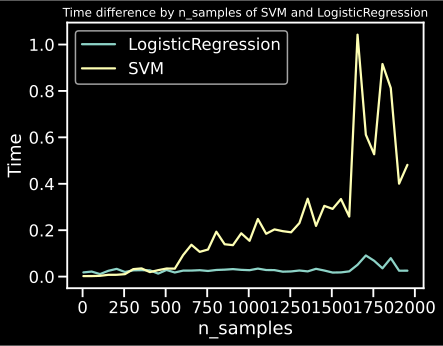

In [18]:
sns.lineplot(x=n_samples_range, y=fitting_time_by_n_samples_lr, palette='blue', label='LogisticRegression')
sns.lineplot(x=n_samples_range, y=fitting_time_by_n_samples_svm, palette='red', label='SVM')
sns.set(rc={'figure.figsize':(9, 6)})
plt.title('Time difference by n_samples of SVM and LogisticRegression')
plt.ylabel('Time')
plt.xlabel('n_samples');

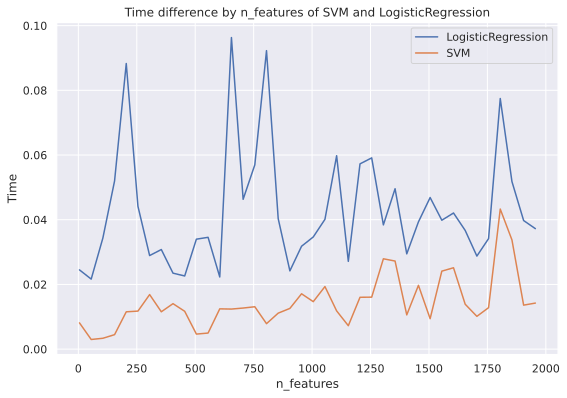

In [19]:
sns.lineplot(x=n_features_range, y=fitting_time_by_n_features_lr, palette='blue', label='LogisticRegression')
sns.lineplot(x=n_features_range, y=fitting_time_by_n_features_svm, palette='red', label='SVM')
sns.set(rc={'figure.figsize':(9, 6)})
plt.title('Time difference by n_features of SVM and LogisticRegression')
plt.ylabel('Time')
plt.xlabel('n_features');

###  <font color='orange'>Задача 2 [2 балла] + [2 бонус]</font>


По сгенерированным ниже данным:

* Обучите модель [SVC(kernel='linear')](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) - это ровно аналог обычного SVM, который вызывается моделью LinearSVC. Остальные параметры оставьте дефолтными
* На приведенном ниже графике (или на построенном таком же графике) выделите объекты, которые были выбраны в качестве опорных векторов. Опорные вектора можно посмотреть через поле `support_vectors_` или `support_` (можно посмотреть документацию по SVC, приведенную выше)
* Что можно сказать о линейной разделимости данных по опорным векторам (что вы видите на изображении)?

* (Бонус) Визуализируйте также разделяющую прямую и зазоры по обе стороны от нее

In [20]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, random_state=12)

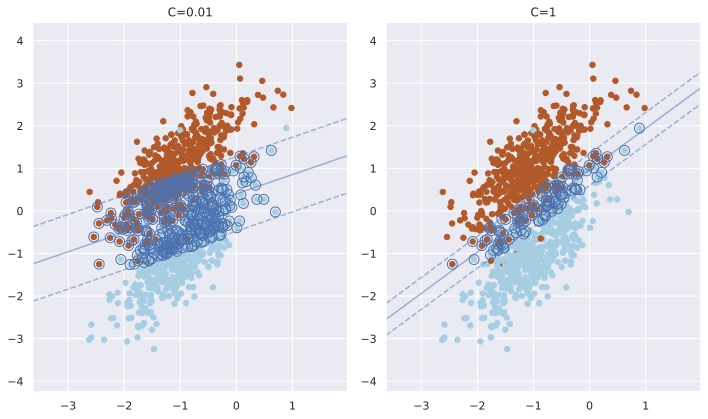

In [27]:
plt.figure(figsize=(10, 6))
for i, C in enumerate([0.01, 1]):
    clf = LinearSVC(C=C, loss="hinge", random_state=42, dual="auto").fit(X, y)
    decision_function = clf.decision_function(X)
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="b",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    plt.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="b",
    )
    plt.title("C=" + str(C))
plt.tight_layout()
plt.show()

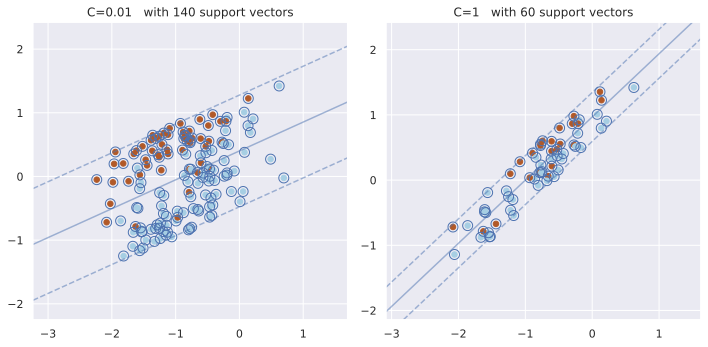

In [36]:
plt.figure(figsize=(10, 5))
k = 70
for i, C in enumerate([0.01, 1]):
    clf = LinearSVC(C=C, loss="hinge", random_state=42, dual="auto").fit(X, y)
    decision_function = clf.decision_function(X)
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    if i % 2 == 0:
        k = 140
    else:
        k = 60
    plt.scatter(support_vectors[:k][:, 0], support_vectors[:k][:, 1], c=y[support_vector_indices][:k], s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        support_vectors[:k],
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="b",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    plt.scatter(
        support_vectors[:k][:, 0],
        support_vectors[:k][:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="b",
    )
    plt.title("C=" + str(C) + '   ' + 'with ' + str(k) + ' support vectors')
plt.tight_layout()
plt.show()

##  <font color='orange'>Бонусное задание [1 бонус]</font>

*  Какое ваше любимое блюдо/еда? Пришлите его фоточку или рецепт или ресторан/кафе/и пр., где его готовят

**Карбонара**

Ингредиенты:
- спагетти (400 гр.), допустимо заменить пенне, букатини или феттучини

- сливки 20-25% (230 мл)

- чеснок свежий (1-2 зубчика)

- бекон или сырокопченая ветчина (330 гр.)

- сыр пармезан (75 гр.)

- яичные желтки (4 шт.)

- масло оливковое (3 ст. л.)

- свежемолотый черный перец

- соль